In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc

In [2]:
data = pd.read_json('data.json', lines=True)
kyiv_df = df1 = pd.read_csv('kyiv_dataset.csv')

In [3]:
kyiv_df.head(5)

,Unnamed: 0.1,Unnamed: 0,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_snow,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_uvindex,hour_severerisk,region_id_x,tf-idf,alarm,datetime_combined
0,25866,25866,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,1017.9,9.9,99.3,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 00:00:00
1,25867,25867,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,1018.0,9.8,99.7,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 01:00:00
2,25868,25868,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,1018.1,9.0,99.7,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 02:00:00
3,25869,25869,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,1018.9,8.1,97.8,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 03:00:00
4,25870,25870,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,1019.0,7.0,98.7,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 04:00:00


In [4]:
kyiv_df1 = kyiv_df.copy()
kyiv_df1 = kyiv_df1.drop_duplicates(subset=['datetime_combined'])
kyiv_df1 = kyiv_df1.dropna(subset=['datetime_combined'])
kyiv_df1['date'] = pd.to_datetime(kyiv_df1['datetime_combined']).dt.date
data['date'] = pd.to_datetime(data['date']).dt.date

kyiv_df1 = kyiv_df1[kyiv_df1['date'].isin(data['date'])]
weather_alarms = pd.merge(kyiv_df1, data, on='date', how='inner')
weather_alarms.head()

,Unnamed: 0.1,Unnamed: 0,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_snow,...,hour_cloudcover,hour_solarradiation,hour_uvindex,hour_severerisk,region_id_x,tf-idf,alarm,datetime_combined,date,lemmatized_text
0,25866,25866,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,99.3,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 00:00:00,2022-02-24,"[mason, clark, george, barros, kateryna, stepa..."
1,25867,25867,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,99.7,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 01:00:00,2022-02-24,"[mason, clark, george, barros, kateryna, stepa..."
2,25868,25868,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,99.7,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 02:00:00,2022-02-24,"[mason, clark, george, barros, kateryna, stepa..."
3,25869,25869,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,97.8,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 03:00:00,2022-02-24,"[mason, clark, george, barros, kateryna, stepa..."
4,25870,25870,5.3,1.9,2.9,1.2,88.9,0.1,4.17,0.0,...,98.7,0.0,0.0,10.0,10,"{'abachev': 0, 'abandon': 0, 'abandoned': 0, '...",0,2022-02-24 04:00:00,2022-02-24,"[mason, clark, george, barros, kateryna, stepa..."


In [5]:
# turning weather into matrix
weather = weather_alarms.copy()
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'region_id_x', 'datetime_combined', 'alarm', 'tf-idf', 'date', 'lemmatized_text']
weather.drop(columns=columns_to_drop, inplace=True)
weather = weather.fillna(0)

weather_matrix = weather.to_numpy()
weather_matrix
sparse_weather = csr_matrix(weather_matrix)
sparse_weather.shape

(7799, 34)

In [6]:
# transformation to matrix with all words
lemmatized_text_str = weather_alarms['lemmatized_text'].apply(lambda x: ' '.join(x))
# remove words which are less then in three reports
tfidf_vectorizer = TfidfVectorizer(min_df=72)
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text_str)

tfidf_matrix.shape

(7799, 6112)

In [7]:
# merge weather matrix with words matrix
combine_matrix = sp.hstack((tfidf_matrix, sparse_weather))
combine_matrix.shape

(7799, 6146)

# Separate the dataset using simple technic 80/20%

## Linear Regression:

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1196
           1       0.68      0.39      0.50       364

    accuracy                           0.82      1560
   macro avg       0.76      0.67      0.69      1560
weighted avg       0.80      0.82      0.80      1560

Confusion Matrix:
[[1129   67]
 [ 221  143]]


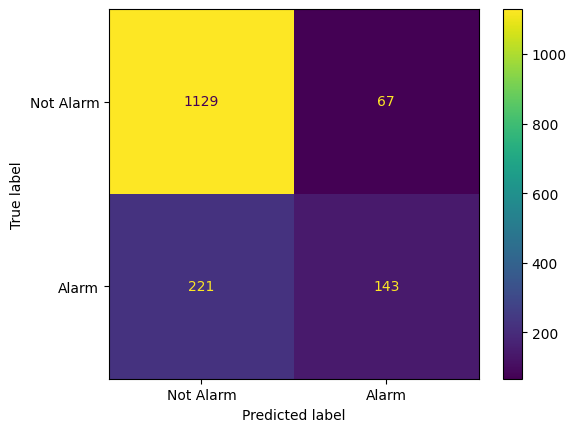

In [8]:
labels = weather_alarms['alarm']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(combine_matrix, labels, test_size=0.20, random_state=42)
lin_1 = LinearRegression()
lin_1.fit(X_train_1, y_train_1)

y_pred_1 = lin_1.predict(X_test_1)    
y_pred_binary_1 = (y_pred_1 > 0.5).astype(int)
print(classification_report(y_test_1, y_pred_binary_1))

cm_1 = confusion_matrix(y_test_1, y_pred_binary_1)
print("Confusion Matrix:")
print(cm_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=['Not Alarm', 'Alarm'])
disp.plot()
plt.show()

## Logistic Regression:

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1196
           1       0.72      0.24      0.36       364

    accuracy                           0.80      1560
   macro avg       0.76      0.61      0.62      1560
weighted avg       0.79      0.80      0.76      1560



C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


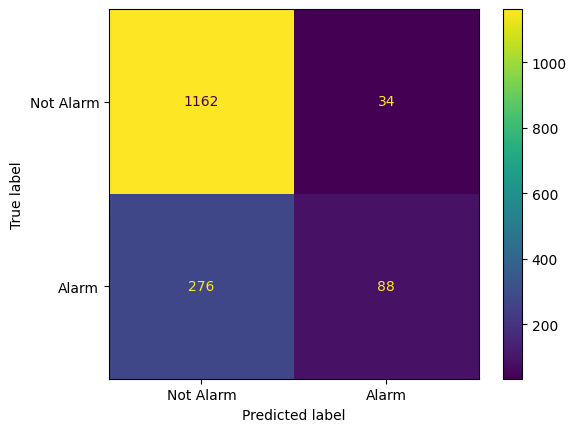

In [10]:
labels = weather_alarms['alarm']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(combine_matrix, labels, test_size=0.20, random_state=42)

log_1 = LogisticRegression(max_iter=1000)
log_1.fit(X_train_3, y_train_3)

y_pred_3 = log_1.predict(X_test_3)
print(classification_report(y_test_3, y_pred_3))

cm_3 = confusion_matrix(y_test_3, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=['Not Alarm', 'Alarm'])
disp.plot()
plt.show()

# Separate the dataset using TimeSeries metod:

## Linear Regression:

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1583
           1       0.14      0.16      0.15       366

    accuracy                           0.65      1949
   macro avg       0.47      0.46      0.46      1949
weighted avg       0.67      0.65      0.66      1949



C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1595
           1       0.00      0.00      0.00       354

    accuracy                           0.82      1949
   macro avg       0.41      0.50      0.45      1949
weighted avg       0.67      0.82      0.74      1949

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1736
           1       0.50      0.00      0.01       213

    accuracy                           0.89      1949
   macro avg       0.70      0.50      0.48      1949
weighted avg       0.85      0.89      0.84      1949

Confusion Matrix:
[[4532  382]
 [ 872   61]]


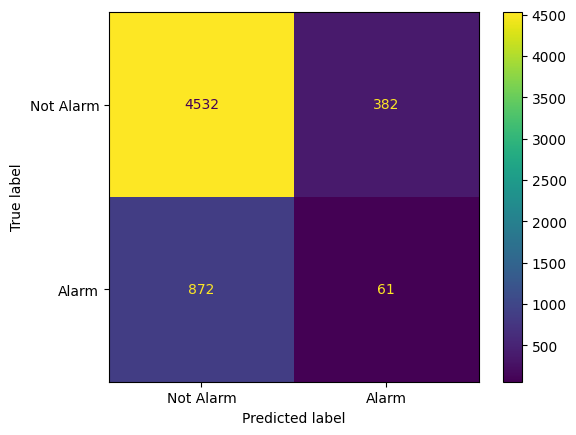

In [11]:
labels = weather_alarms['alarm']
tscv = TimeSeriesSplit(n_splits=3)

true_labels = []
predicted_labels = []

for train_index, test_index in tscv.split(combine_matrix):
    X_train_2, X_test_2 = combine_matrix[train_index], combine_matrix[test_index]
    y_train_2, y_test_2 = labels.iloc[train_index], labels.iloc[test_index]
    
    lin_2 = LinearRegression()
    lin_2.fit(X_train_2, y_train_2)
    
    y_pred_2 = lin_2.predict(X_test_2)
    y_pred_binary_2 = (y_pred_2 > 0.5).astype(int)
    
    print(classification_report(y_test_2, y_pred_binary_2))

    true_labels.extend(y_test_2)
    predicted_labels.extend(y_pred_binary_2)

    # cm_2 = confusion_matrix(y_test_2, y_pred_binary_2)
    # print("Confusion Matrix:")
    # print(cm_2)

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Alarm', 'Alarm'])
disp.plot()
plt.show()

## Logistic Regression:

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1583
           1       0.20      0.06      0.09       366

    accuracy                           0.78      1949
   macro avg       0.51      0.50      0.48      1949
weighted avg       0.70      0.78      0.73      1949



C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1595
           1       0.34      0.09      0.15       354

    accuracy                           0.80      1949
   macro avg       0.58      0.53      0.52      1949
weighted avg       0.74      0.80      0.75      1949

              precision    recall  f1-score   support

           0       0.87      0.41      0.56      1736
           1       0.09      0.48      0.15       213

    accuracy                           0.42      1949
   macro avg       0.48      0.45      0.36      1949
weighted avg       0.78      0.42      0.52      1949



C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


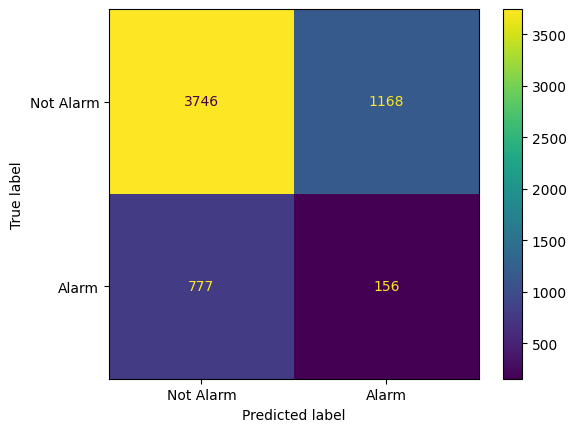

In [12]:
labels = weather_alarms['alarm']
tscv = TimeSeriesSplit(n_splits=3)

true_labels = []
predicted_labels = []
for train_index, test_index in tscv.split(combine_matrix):
    X_train_4, X_test_4 = combine_matrix[train_index], combine_matrix[test_index]
    y_train_4, y_test_4 = labels.iloc[train_index], labels.iloc[test_index]
    
    log_2 = LogisticRegression(max_iter=1000)
    log_2.fit(X_train_4, y_train_4)

    y_pred_4 = log_2.predict(X_test_4)
    print(classification_report(y_test_4, y_pred_4))

    # cm_4 = confusion_matrix(y_test_4, y_pred_4)
    # print("Confusion Matrix:")
    # print(cm_4)
    
    true_labels.extend(y_test_4)
    predicted_labels.extend(y_pred_4)

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Alarm', 'Alarm'])
disp.plot()
plt.show()

# Top 20 features for each of models:

In [13]:
models = [log_1, log_2]
model_names = ['Logistic Regression 1', 'Logistic Regression 2']

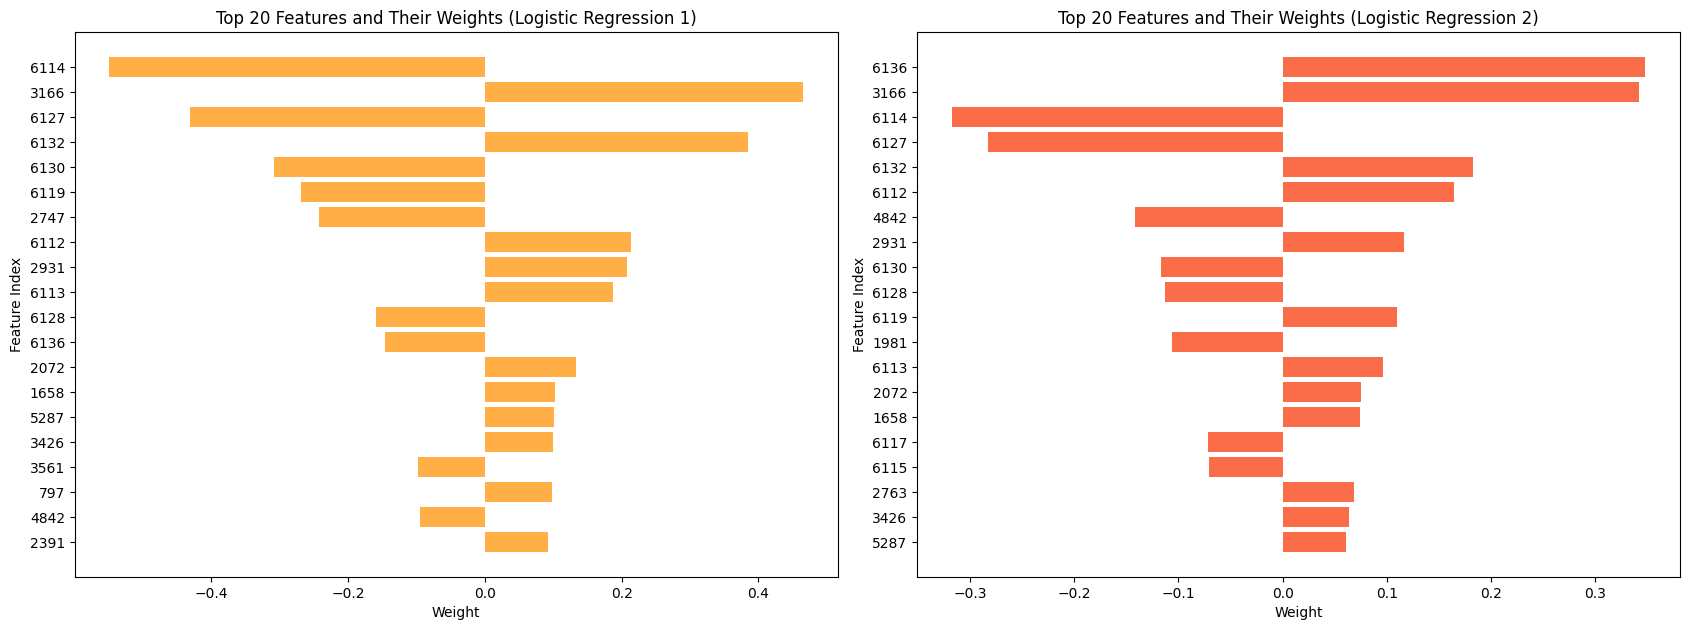

In [14]:
plt.figure(figsize=(17, 12)) 
colors = ['#FFAF45', '#FB6D48', '#D74B76', '#673F69']

for i, model in enumerate(models, 1):
    coefficients = model.coef_[0]
    
    top_indices = np.argsort(np.abs(coefficients))[::-1][:20]
    top_coefficients = coefficients[top_indices]

    plt.subplot(2, 2, i) 
    plt.barh(range(len(top_indices)), top_coefficients, color=colors[i-1])
    plt.yticks(range(len(top_indices)), top_indices)
    plt.xlabel('Weight')
    plt.ylabel('Feature Index')
    plt.title(f'Top 20 Features and Their Weights ({model_names[i-1]})')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()